In [1]:
#Editing Features
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import mlflow
from scipy.ndimage import zoom
from unxpass.components.utils import log_model, load_model
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset, CompletedPassesDataset, FailedPassesDataset, SamePassesDataset
from unxpass.components import pass_value, pass_value_custom, pass_success, pass_success_custom
pd.options.mode.chained_assignment = None
from os import listdir
from os.path import isfile, join

In [10]:
homedr = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_intended"
targetdr = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/feature_testing"
endlocs = pd.read_parquet(f"{homedr}/x_endlocation.parquet")
startlocs = pd.read_parquet(f"{homedr}/x_startlocation.parquet")
intendedend = pd.read_parquet(f"{homedr}/x_intended_endlocation.parquet")
success = pd.read_parquet(f"{homedr}/y_success.parquet")

success
game_id        action_id        
DFL-MAT-J03YDU 0            True
               2             NaN
               5            True
               7            True
               9             NaN
...                          ...
DFL-MAT-J03YMB 1400         True
               1401         True
               1403          NaN
               1404         True
               1406         True

[279727 rows x 1 columns]

In [18]:
failsidxs = success[~success.values].index

In [22]:
intendedend.shape, endlocs.shape, startlocs.shape
endlocs.loc[failsidxs, "end_x_a0"] = intendedend.loc[failsidxs, "end_x_a0"]
endlocs.loc[failsidxs, "end_y_a0"] = intendedend.loc[failsidxs, "end_y_a0"]

In [25]:
allfiles = [f for f in listdir(homedr) if isfile(join(homedr, f))]
for file in allfiles:
    print(file)
    if file == "x_endlocation.parquet":
        endlocs.to_parquet(f"{targetdr}/x_endlocation.parquet")
    else:
        df = pd.read_parquet(f"{homedr}/{file}")
        df.to_parquet(f"{targetdr}/{file}")

x_speed.parquet
y_concedes_xg.parquet
x_endlocation.parquet
y_scores_xg.parquet
y_scores.parquet
x_freeze_frame_360.parquet
x_startlocation.parquet
y_concedes.parquet
y_success.parquet
x_intended_endlocation.parquet


In [17]:
def addVals(idx, amount, df, column, changeVal = None, otherVal = None):
    if changeVal is not None and otherVal is not None:
        df[column] = otherVal
        df[column].loc[idx] = changeVal
    else:
        df[column].loc[idx] = df[column].loc[idx] + amount
    return df
def editFiles(homedr, targetdr, stopping, idx, amount, allFilter = None, rmvOthers = False, changeVal = None, otherVal = None):
    """
    stopping - file of interest
    allFilter - determine if only those within allFilter should be returned
    rmvOthers - set all others to 0
    amount - amount to add to the column
    changeVal - set to an entirely new value instead of adding like amount
    otherVal - value of others not in changeVal
    """
    allfiles = [f for f in listdir(homedr) if isfile(join(homedr, f))]
    for file in allfiles:
        df = pd.read_parquet(f"{homedr}/{file}")
        print(f"Reading {file}")
        if allFilter is not None:
            df = df.loc[allFilter]
        if file == stopping:
            if rmvOthers:
                df[stopping.split(".")[0][2:]] = 0
            df = addVals(idx, amount, df, stopping.split(".")[0][2:], changeVal, otherVal)
        #print(df)
        df.to_parquet(f"{targetdr}/{file}")


In [18]:
editFiles(homedr, targetdr, "y_concedes_xg.parquet", idxs, 0.7)

Reading x_speed.parquet
Reading y_concedes_xg.parquet
Reading x_endlocation.parquet
Reading y_scores_xg.parquet
Reading y_scores.parquet
Reading x_freeze_frame_360.parquet
Reading x_startlocation.parquet
Reading y_concedes.parquet
Reading y_success.parquet


In [5]:
freeze_frame = pd.read_parquet(f"{homedr}/x_freeze_frame_360.parquet")
success = pd.read_parquet(f"{homedr}/y_success.parquet")
ends = pd.read_parquet(f"{homedr}/x_endlocation.parquet")
endvaluesframe = freeze_frame.join(ends).join(success)
endvaluesframe
def distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2)**2 + (y1-y2)**2)
def closestTeammate(row):
    end_x = row['end_x_a0']
    end_y = row['end_y_a0']
    frame = row['freeze_frame_360_a0']
    if frame is None:
        return 10000, 10000
    teammates = [player for player in frame if player['teammate'] and not player['actor']]
    teammates_x = [player['x'] for player in teammates]
    teammates_y = [player['y'] for player in teammates]
    opponents = [player for player in frame if not player['teammate']]
    opponents_x = [player['x'] for player in opponents]
    opponents_y = [player['y'] for player in opponents]
    team_distances = [10000]
    opp_distances = [10000]
    for idx in range(len(teammates)):
        teammate_dist = distance(end_x, teammates_x[idx], end_y, teammates_y[idx])
        team_distances.append(teammate_dist)
    for idx in range(len(opponents)):
        opp_dist = distance(end_x, opponents_x[idx], end_y, opponents_y[idx])
        opp_distances.append(opp_dist)
    #print(end_x, end_y)
    #print([[opponents_x[i], opponents_y[i]] for i in range(len(opponents))])
    #print(opp_distances)
    #print(team_distances, opp_distances)
    return min(team_distances), min(opp_distances)
samplerow = ("DFL-MAT-J03YE4", 0)
endvaluesframe[['closestTeammate', 'closestOpp']] = pd.DataFrame(
    endvaluesframe.apply(lambda row: closestTeammate(row), axis=1).tolist(),
    index=endvaluesframe.index
)
def getIdx(df, threshold, successOnly = False, failOnly = False, col = "closestTeammate"):
    filtered = df[df[col] < threshold]
    if successOnly:
        return filtered[filtered['success']].index
    if failOnly:
        return filtered[~filtered['success']].index
    return filtered.index


In [6]:
DATA_DIR = Path("../stores/")
custom_path = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_features_fixed"

dataset_fail = partial(FailedPassesDataset, path = custom_path)
value_fail_offensive = pass_value_custom.SoccerMapComponent(model = pass_value_custom.PytorchSoccerMapModel(), offensive = True)
off_data = value_fail_offensive.initialize_dataset(dataset_fail, model_name = 'val')
off_labs = off_data.labels
off_feats = off_data.features
value_fail_defensive = pass_value_custom.SoccerMapComponent(model = pass_value_custom.PytorchSoccerMapModel(), offensive = False)
def_data = value_fail_defensive.initialize_dataset(dataset_fail, model_name = 'val')
def_labs = def_data.labels
def_feats = def_data.features

{'startlocation': ['start_x_a0', 'start_y_a0'], 'endlocation': ['end_x_a0', 'end_y_a0'], 'freeze_frame_360': ['freeze_frame_360_a0']}


[01/06/25 14:30:30] INFO     Loading dataset from                                                   ]8;id=9213;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=55537;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_feat                
                             ures_fixed                                                                            

{'startlocation': ['start_x_a0', 'start_y_a0'], 'endlocation': ['end_x_a0', 'end_y_a0'], 'freeze_frame_360': ['freeze_frame_360_a0']}


[01/06/25 14:30:45] INFO     Loading dataset from                                                   ]8;id=829998;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=182682;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/all_feat                
                             ures_fixed                                                                            

In [7]:
def_idxs = def_labs[def_labs['concedes_xg'] > 0].index
off_idxs = off_labs[off_labs['scores_xg'] > 0].index
def_idxs.intersection(off_idxs)

MultiIndex([('DFL-MAT-J03YED',  862),
            ('DFL-MAT-J03YEN', 1144),
            ('DFL-MAT-J03YET', 1119),
            ('DFL-MAT-J03YFR',   54),
            ('DFL-MAT-J03YHU', 1520),
            ('DFL-MAT-J03YIP',  991),
            ('DFL-MAT-J03YJT',   13),
            ('DFL-MAT-J03YKL', 1637),
            ('DFL-MAT-J03YKO',  710),
            ('DFL-MAT-J03YLR',  161)],
           names=['game_id', 'action_id'])

In [8]:
dbpath = "/home/lz80/rdf/sp161/shared/soccer-decision-making/Bundesliga/buli_all.sql"

db = SQLiteDatabase(dbpath)
db.actions(game_id = "DFL-MAT-J03YDU")

original_event_id  period_id  time_seconds  \
game_id        action_id                                              
DFL-MAT-J03YDU 0          18453000000006.0          1           0.0   
               1                      None          1           1.5   
               2          18453000000007.0          1           3.0   
               3          18453000000013.0          1          23.0   
               4                      None          1          25.0   
...                                    ...        ...           ...   
               1484                   None          2        3100.5   
               1485       18453000001460.0          2        3101.0   
               1486       18453000001461.0          2        3103.0   
               1487                   None          2        3106.0   
               1488       18453000001462.0          2        3109.0   

                                 team_id       player_id    start_x  \
game_id        action_id                                              
DFL-MAT-J03YDU 0          DFL-CLU-00000G  DFL-OBJ-0002AU  53.877178   
               1          DFL-CLU-00000G  DFL-OBJ-0000LT  83.250256   
               2          DFL-CLU-00000G  DFL-OBJ-0000LT  81.088768   
               3          DFL-CLU-00000E  DFL-OBJ-0000YO  62.364490   
               4          DFL-CLU-00000E  DFL-OBJ-0000ZM  64.834762   
...                                  ...             ...        ...   
               1484       DFL-CLU-00000G  DFL-OBJ-0027T1  68.563717   
               1485       DFL-CLU-00000G  DFL-OBJ-0027T1  60.988859   
               1486       DFL-CLU-00000G  DFL-OBJ-0000RP  50.972678   
               1487       DFL-CLU-00000G  DFL-OBJ-0000IA  34.751869   
               1488       DFL-CLU-00000G  DFL-OBJ-0000IA  33.304444   

                            start_y      end_x      end_y  bodypart_id  \
game_id        action_id                                                 
DFL-MAT-J03YDU 0          34.350928  83.250256  37.767975            5   
               1          37.767975  81.088768  34.360342            0   
               2          34.360342  40.213486  59.559885            5   
               3           3.893466  64.834762   9.682678            5   
               4           9.682678  62.094304   6.717472            0   
...                             ...        ...        ...          ...   
               1484       29.672493  60.988859  25.003470            0   
               1485       25.003470  51.204266  28.420517            5   
               1486       29.841933  34.751869  45.336310            5   
               1487       45.336310  33.304444  42.239317            0   
               1488       42.239317  39.364330  35.273437            5   

                          type_id  result_id possession_team_id  \
game_id        action_id                                          
DFL-MAT-J03YDU 0                0          1     DFL-CLU-00000G   
               1               21          1               None   
               2                0          0     DFL-CLU-00000G   
               3                2          1     DFL-CLU-00000E   
               4               21          1               None   
...                           ...        ...                ...   
               1484            21          1               None   
               1485             0          1     DFL-CLU-00000G   
               1486             0          1     DFL-CLU-00000G   
               1487            21          1               None   
               1488             0          1     DFL-CLU-00000G   

                         play_pattern_name  under_pressure  \
game_id        action_id                                     
DFL-MAT-J03YDU 0             From Kick Off               0   
               1                      None               0   
               2             From Kick Off               0   
               3                

In [9]:
idx_def  = def_labs[def_labs['concedes_xg'] > 0].index
idx_off = off_labs[off_labs['scores_xg'] > 0].index
both = idx_def.intersection(idx_off)

In [25]:
both

MultiIndex([('DFL-MAT-J03YED',  862),
            ('DFL-MAT-J03YEN', 1144),
            ('DFL-MAT-J03YET', 1119),
            ('DFL-MAT-J03YFR',   54),
            ('DFL-MAT-J03YHU', 1520),
            ('DFL-MAT-J03YIP',  991),
            ('DFL-MAT-J03YJT',   13),
            ('DFL-MAT-J03YKL', 1637),
            ('DFL-MAT-J03YKO',  710),
            ('DFL-MAT-J03YLR',  161)],
           names=['game_id', 'action_id'])

In [33]:
from unxpass.visualizers_made import animationHelper, get_animation_from_raw
iterval = 9
def getVals(idx):
    action = db.actions(game_id = idx[0]).loc[idx]
    game_id = action["original_event_id"]
    event, tracking = animationHelper(idx[0])
    return float(game_id), event, tracking
def getnext10(idx):
    return db.actions(game_id = idx[0]).loc[idx : (idx[0], idx[1] + 10)]
game_id, event, tracking = getVals(both[iterval])
next10 = getnext10(both[iterval])
next10

original_event_id  period_id  time_seconds  \
game_id        action_id                                              
DFL-MAT-J03YLR 161        18481500000194.0          1         431.0   
               162        18481500000151.0          1         445.0   
               163        18481500000152.0          1         451.0   
               164        18481500000159.0          1         451.0   
               165        18481500000153.0          1         452.0   
               166        18481500000154.0          1         453.0   
               167        18481500000156.0          1         460.0   
               168                    None          1         461.0   
               169        18481500000158.0          1         462.0   
               170        18481500000160.0          1         566.0   
               171                    None          1         568.0   

                                 team_id       player_id    start_x  \
game_id        action_id                                              
DFL-MAT-J03YLR 161        DFL-CLU-00000E  DFL-OBJ-0000DT  78.894083   
               162        DFL-CLU-00000E  DFL-OBJ-0001CE  94.285036   
               163        DFL-CLU-000004  DFL-OBJ-00264N  98.892095   
               164        DFL-CLU-000004  DFL-OBJ-0027AK   8.659621   
               165        DFL-CLU-000004  DFL-OBJ-0027AK  96.113039   
               166        DFL-CLU-00000E  DFL-OBJ-0027BH  52.522000   
               167        DFL-CLU-000004  DFL-OBJ-002GC0  53.645590   
               168        DFL-CLU-000004  DFL-OBJ-0027RM  20.789042   
               169        DFL-CLU-000004  DFL-OBJ-0027RM   8.418383   
               170        DFL-CLU-00000E  DFL-OBJ-0001CE  50.968430   
               171        DFL-CLU-00000E  DFL-OBJ-0027BH  34.197599   

                            start_y      end_x      end_y  bodypart_id  \
game_id        action_id                                                 
DFL-MAT-J03YLR 161        55.431568  83.352152  51.402653            5   
               162        33.131337  52.522000  31.333387            0   
               163        25.728298  99.721952  32.637698            5   
               164        34.972210   8.659621  34.972210            0   
               165        34.868663  95.167388  34.868663            5   
               166        31.333387  52.522000  31.333387            0   
               167        46.785966  20.789042  22.311251            5   
               168        22.311251   8.418383  24.099788            0   
               169        24.099788   0.000000   0.000000            0   
               170        34.232699  34.197599  32.302962            5   
               171        32.302962  36.957356  30.693279            0   

                          type_id  result_id possession_team_id  \
game_id        action_id                                          
DFL-MAT-J03YLR 161              0          0     DFL-CLU-00000E   
               162             11          0     DFL-CLU-00000E   
               163             22          1     DFL-CLU-000004   
               164              9          1     DFL-CLU-000004   
               165              0          0     DFL-CLU-000004   
               166              9          1     DFL-CLU-00000E   
               167              0          1     DFL-CLU-000004   
               168             21          1               None   
               169             11          1     DFL-CLU-000004   
               170              0          1     DFL-CLU-00000E   
               171             21          1               None   

                         play_pattern_name  under_pressure  \
game_id        action_id                                     
DFL-MAT-J03YLR 161                    None               0   
               162                    None               0   
               163                    None               0   
               164              

range(20782, 23782, 30)


[01/06/25 14:51:54] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=781587;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=846581;file:///home/lz80/un-xPass/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\

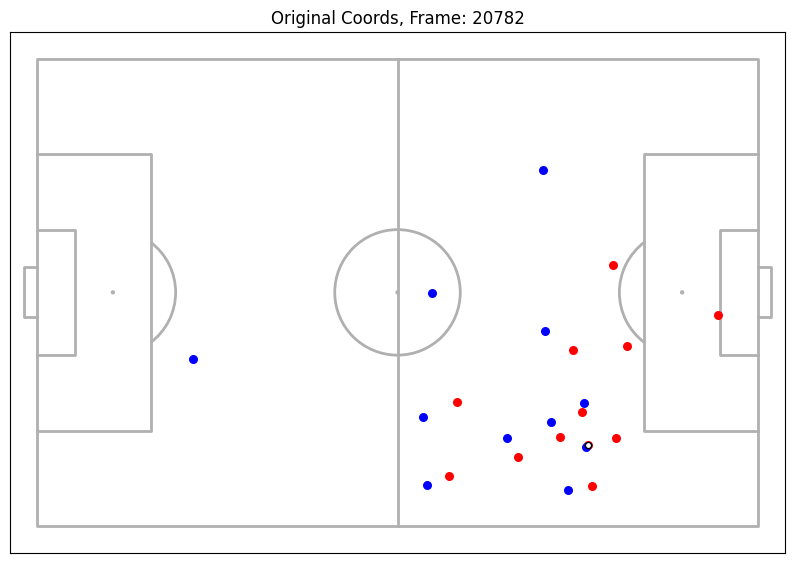

In [31]:
framerate = 200
get_animation_from_raw(float(game_id), framerate, event, tracking, custom_frames = None, show = True, add_frames = 3000, frameskip = 30)
#not enough actions in between?